# Model Tuning and Evaluation

Here we will evalute our baseline model and attempt to build a better model using sentiment analysis and a voting classifier. 

In [24]:
# import our libraries

import pandas as pd
import numpy as np
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer


from xgboost import XGBClassifier

from collections import Counter
from googletrans import Translator, LANGUAGES

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# import dataset

translated_df = pd.read_csv('../data/translated.csv')
translated_df.head()

,subreddit,merged_text
0,1,Fix to not being able to attack? Has anybody f...
1,1,Attack glitch during Regi raids 2 raids today ...
2,1,[Bug?] Can’t seem to earn or collect pokecoins...
3,1,"[Bug?] AR suddenly freezes Using an iPhone 11,..."
4,1,3 hour incense event personal results For any ...


In [26]:
# remove duplicate entries where text is the same
translated_df = translated_df.drop_duplicates('merged_text')

Now we get get sentiment scores for our text.

In [27]:
# thanks to Hov
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

translated_df['sentiment'] = translated_df['merged_text'].apply(get_compound_sentiment)

In [28]:
get_text_data = FunctionTransformer(lambda x: x['merged_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x['sentiment'], validate = False)

In [29]:
# create baseline model
translated_df['subreddit'].value_counts()

1    10611
0     8642
Name: subreddit, dtype: int64

We will guess that all posts are from TheSilphRoad subreddit as it is our majority class.

In [30]:
# create train_test_split to evaluate our baseline model
X = translated_df.drop('merged_text', axis = 1)
y = translated_df['subreddit']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# create predictions for train and test set
y_train_preds = np.full_like(y_train, 1)
y_test_preds = np.full_like(y_test, 1)

print(f'Baseline accuracy on training data: {round(accuracy_score(y_train, y_train_preds), 2)}')
print(f'Baseline accuracy on testing data: {round(accuracy_score(y_test, y_test_preds), 2)}')

Baseline accuracy on training data: 0.55
Baseline accuracy on testing data: 0.55


Here we see that we have an baseline accuracy of 55% on both our training and testing data which is expected as about 55% of the posts we have are from TheSilphRoad subreddit and we used stratify for our train/test split. 

In [32]:
# create a custom stop words list to remove all similar words we found in the previous notebook

# start with the base english stopwords
new_stopwords = stopwords.words('english')

# add stopwords that will easily identify a silph post
# also added stopwords that are common across both subreddits and stop words as a result and lemmatizing and stemming
custom_words = ['silph', 'road', 'silphroad', 'thesilphroad', 'pokemon', 'go', 'get', 'one', 'like', 'would', 'know', 'time', 'game', 'shiny', 
               'https', 'raid', 'anyone', 'got', 'new', 'event', 'day', 'level', 'even', 'com', 'raids', 'still', 'people', 'also', 'since',
               'use', 'catch', 'amp', 'see', 'want', 'could', 'first', 'research', 'shadow', 'think', 'else', 'way', 'niantic', 'make', 
               'back', 'really', 'need', 'eggs', 'community', 'something', 'much', 'good', 'able', "'d", "'ll", "'re", "'s", "'ve", 'abl', 
                'abov', 'ani', 'anyon', 'becaus', 'befor', 'commun', 'doe', 'dure', 'egg', 'els', 'ha', 'hi', 'http', 'might', 'must', 
                "n't", 'onc', 'onli', 'ourselv', 'peopl', 'realli', 'sha', 'shini', 'sinc', 'someth', 'themselv', 'thi', 'veri', 'wa', 
                'whi', 'wo', 'yourselv', 'becau', 'el']

new_stopwords.extend(custom_words)

In [33]:
# custom preprocessing of text 
# thanks to the following article for the code: https://kavita-ganesan.com/how-to-use-countvectorizer/#CountVectorizer-Plain-and-Simple
lemmatizer = WordNetLemmatizer()

def lemma_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

porter_stemmer = PorterStemmer()
def stem_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [34]:
# generate our pipelines
cvec_sentiment_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words = new_stopwords, strip_accents = 'unicode'))
            ]))
    ])),
    ('vote', VotingClassifier([
        ('logr', LogisticRegression(solver = 'liblinear', max_iter = 10000)),
        ('nb', MultinomialNB()),
        ('rforest', RandomForestClassifier()),
        ('bag', BaggingClassifier()),
        ('knn', KNeighborsClassifier()),
        ('etree', ExtraTreesClassifier()),
        ('xgb', XGBClassifier()),
        ('svc', SVC()), 
        ('histboost', HistGradientBoostingClassifier)
    ]))
])

tfidf_sentiment_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tfidf', TfidfVectorizer(stop_words = new_stopwords, strip_accents = 'unicode')),
                ('densify', FunctionTransformer(lambda x: x.todense(), accept_sparse=True))
            ]))
    ])),
    ('vote', VotingClassifier([
        ('logr', LogisticRegression(solver = 'liblinear', max_iter = 10000)),
        ('nb', MultinomialNB()),
        ('rforest', RandomForestClassifier()),
        ('bag', BaggingClassifier()),
        ('knn', KNeighborsClassifier()),
        ('etree', ExtraTreesClassifier()),
        ('xgb', XGBClassifier()),
        ('svc', SVC()),
        ('histboost', HistGradientBoostingClassifier())
    ]))
])

In [35]:
# create gridsearch parameters

cvec_sentiment_params = {
    'features__text_features__cvec__preprocessor': [lemma_preprocessor, stem_preprocessor],
    'features__text_features__cvec__ngram_range': [(1,1), (1,2), (1,3), (2,3),(2,2),(3,3)],
    'features__text_features__cvec__max_df': np.linspace(0.8, 1.0, 10),
    'features__text_features__cvec__min_df': range(1,4),
    'features__text_features__cvec__max_features': range(2000, 100000, 100),
    'vote__logr__penalty': ['l1', 'l2'],
    'vote__logr__C': np.linspace(0.0001, 1, 1000),
    'vote__nb__alpha': np.logspace(0, 6, 100),
    'vote__rforest__n_estimators': np.linspace(50, 1000, 50),
    'vote__rforest__max_depth': range(10, 101, 2),
    'vote__rforest__min_samples_split': range(2, 21, 2),
    'vote__rforest__min_samples_leaf': range(1, 50, 2), 
    'vote__rforest__max_features': ['sqrt', 'log2'],
    'vote__bag__base_estimator': [RandomForestClassifier(max_depth = 5), RandomForestClassifier(max_depth = 10), RandomForestClassifier(max_depth = 15)], 
    'vote__bag__n_estimators': range(10, 1000, 50),
    'vote__bag__max_samples': range(2, 21), 
    'vote__bag__max_features': range(10, 200, 10),
    'vote__knn_n_neighbors': range(3, 101, 2),
    'vote__xgb__n_estimators': range(10, 1000, 50), 
    'vote__xgb__learning_rate': [0.01, 0.1, 0.3, 0.7],
    'vote__xgb__max_depth': [2, 5, 10], 
    'vote__xgb__min_child_weight': range(2, 100, 2), 
    'vote__svc__C': np.linspace(0.001, 1, 100), 
    'vote__svc__kernel': ['poly', 'rbf', 'linear'], 
    'vote__svc__degree': range(2, 10), 
    'vote__histboost__loss': ['auto', 'binary_crossentropy', 'categorical_crossentropy'],
    'vote__histboost__learning_rate': np.linspace(0.01, 1, 100),
    'vote__histboost__max_iter': range(100, 10000, 100),
    'vote__histboost__max_leaf_nodes': range(2, 101, 2), 
    'vote__histboost__max_depth': range(10, 101, 2),
    'vote__histboost__min_samples_leaf': range(1, 50, 2)
}

tfidf_sentiment_params = {
    'features__text_features__tfidf__preprocessor': [lemma_preprocessor, stem_preprocessor],
    'features__text_features__tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,3),(2,2),(3,3)],
    'features__text_features__tfidf__max_df': np.linspace(0.8, 1.0, 10),
    'features__text_features__tfidf__min_df': range(1,4),
    'features__text_features__tfidf__max_features': range(2000, 100000, 100),
    'vote__logr__penalty': ['l1', 'l2'],
    'vote__logr__C': np.linspace(0.0001, 1, 1000),
    'vote__nb__alpha': np.logspace(0, 6, 100),
    'vote__rforest__n_estimators': np.linspace(50, 1000, 50),
    'vote__rforest__max_depth': range(10, 101, 2),
    'vote__rforest__min_samples_split': range(2, 21, 2),
    'vote__rforest__min_samples_leaf': range(1, 50, 2), 
    'vote__rforest__max_features': ['sqrt', 'log2'],
    'vote__bag__base_estimator': [RandomForestClassifier(max_depth = 5), RandomForestClassifier(max_depth = 10), RandomForestClassifier(max_depth = 15)], 
    'vote__bag__n_estimators': range(10, 1000, 50),
    'vote__bag__max_samples': range(2, 21), 
    'vote__bag__max_features': range(10, 200, 10),
    'vote__knn_n_neighbors': range(3, 101, 2),
    'vote__xgb__n_estimators': range(10, 1000, 50), 
    'vote__xgb__learning_rate': [0.01, 0.1, 0.3, 0.7],
    'vote__xgb__max_depth': [2, 5, 10], 
    'vote__xgb__min_child_weight': range(2, 100, 2), 
    'vote__svc__C': np.linspace(0.001, 1, 100), 
    'vote__svc__kernel': ['poly', 'rbf', 'linear'], 
    'vote__svc__degree': range(2, 10),
    'vote__histboost__loss': ['auto', 'binary_crossentropy', 'categorical_crossentropy'],
    'vote__histboost__learning_rate': np.linspace(0.01, 1, 100),
    'vote__histboost__max_iter': range(100, 10000, 100),
    'vote__histboost__max_leaf_nodes': range(2, 101, 2), 
    'vote__histboost__max_depth': range(10, 101, 2),
    'vote__histboost__min_samples_leaf': range(1, 50, 2)
}

In [ ]:
cvec_sentiment_gs = HalvingRandomSearchCV(estimator = cvec_sentiment_pipe,
                                param_grid = cvec_sentiment_params,
                                n_candidates = 10000,
                                verbose = 2, 
                                cv = 5, 
                                n_jobs = 50)

tfidf_sentiment_gs = HalvingRandomSearchCV(estimator = tfidf_sentiment_pipe,
                                param_grid = tfidf_sentiment_params,
                                n_candidates = 10000,
                                verbose = 2, 
                                cv = 5, 
                                n_jobs = 50)

cvec_sentiment_gs.fit(X_train, y_train)
tfidf_sentiment_gs.fit(X_train, y_train)

In [27]:
models = ['Count Vectorizer Logistic Regression', 'TFIDF Logistic Regression', 'Count Vectorizer Naive Bayes', 'TFIDF Multinomial Naive Bayes',
         'Count Vectorizer K Nearest Neighbors', 'TFIDF K Nearest Neighbors']

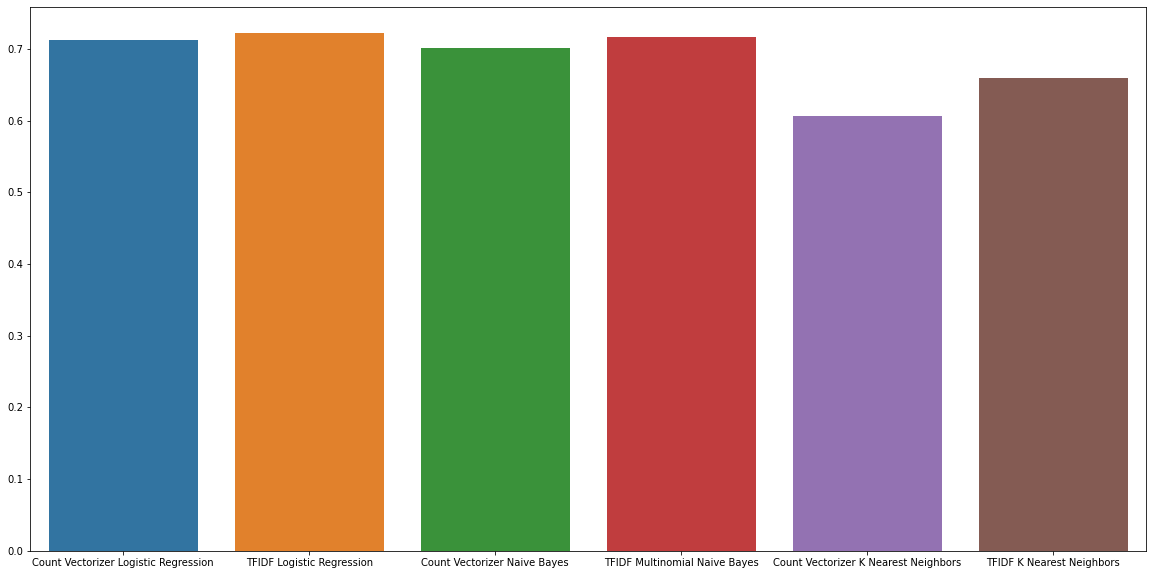

In [31]:
model_train_score = [0.712, 0.722, 0.701, 0.717, 0.607, 0.659]
plt.figure(figsize = (20, 10))
sns.barplot(x = models, y = model_train_score);